## Demo 1: Wasserstein distance estimation on toy example
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/deel-lip/blob/master/docs/notebooks/demo1.ipynb)

In this notebook we will see how to estimate the wasserstein distance with a Neural net by using
the Kantorovich-Rubinestein dual representation.


### Wasserstein distance

The wasserstein distance measure the distance between two probability distribution. Wikipedia article gives a more intuitive definition of it:

> Intuitively, if each distribution is viewed as a unit amount of "dirt" piled on M, the metric is the minimum "cost" of turning one pile into the other, which is assumed to be the amount of dirt that needs to be moved times the mean distance it has to be moved. Because of this analogy, the metric is known in computer science as the earth mover's distance.

Mathematically it is defined as:

$$
W_1(\mu,\nu) = \inf_{\pi \in \Pi(\mu,\nu)}\underset{x,z \sim \pi}{\mathbb{E}}\parallel \textbf{x}-\textbf{z} \parallel
$$

where $\Pi(\mu,\nu)$ is the set of all probability measures on $\Omega\times \Omega$ with marginals $\mu$ and $\nu$. In most case this equation is not tractable.

### KR dual formulation

In our setup, the KR dual formulation is stated as following:
$$ W_1(\mu, \nu) = \sup_{f \in Lip_1(\Omega)} \underset{\textbf{x} \sim \mu}{\mathbb{E}} \left[f(\textbf{x} )\right] -\underset{\textbf{x}  \sim \nu}{\mathbb{E}} \left[f(\textbf{x} )\right] $$

This state the problem as an optimization problem over the 1-lipschitz functions.
Therefore k-Lipschitz networks allows us to solve this maximization problem.

[1] C. Anil, J. Lucas, et R. Grosse, « Sorting out Lipschitz function approximation », arXiv:1811.05381 [cs, stat], nov. 2018.


We will illustrate this on a synthetic image dataset where $W_1$ is known.

In [ ]:
# pip install deel-lip -qqq

In [1]:
from datetime import datetime
import os
import numpy as np
import math

import matplotlib.pyplot as plt 

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from deel.lip.layers import SpectralConv2D, SpectralDense, FrobeniusDense
from deel.lip.activations import MaxMin, GroupSort, FullSort
from deel.lip.losses import KR, HKR
from deel.lip.model import Model

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_d1mx9in because the default path (/home/thibaut.boissin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2021-09-08 18:20:20.330918: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Parameters input images

The synthetic dataset will be composed image with black or white squares allowing us to check if the computed wasserstein distance is correct. One distribution will be the set of black images, while the other will be the set of images with a square on it. these two distribution are diracs, and the wasserstein distance can be analyticaly computed:

In the case to the two diracs the wasserstein distance is then the L1 distance between the two images.

In [2]:
img_size = 64 
frac_value = 0.3  # proportion of the center square

### Generate images

In [3]:
def generate_toy_images(shape,frac=0,v=1):
    """
    function that generate a single image.
    
    Args:
        shape: shape of the output image
        frac: proportion of the center square
        value: value assigned to the center square
    """
    img = np.zeros(shape)
    if frac==0:
        return img
    frac=frac**0.5
    #print(frac)
    l=int(shape[0]*frac)
    ldec=(shape[0]-l)//2
    #print(l)
    w=int(shape[1]*frac)
    wdec=(shape[1]-w)//2
    img[ldec:ldec+l,wdec:wdec+w,:]=v
    return img


def binary_generator(batch_size,shape,frac=0):
    """
    generate a batch with half of black images, hald of images with a white square.
    """
    batch_x = np.zeros(((batch_size,)+(shape)), dtype=np.float16)
    batch_y=np.zeros((batch_size,1), dtype=np.float16)
    batch_x[batch_size//2:,]=generate_toy_images(shape,frac=frac,v=1)
    batch_y[batch_size//2:]=1
    while True:
        yield  batch_x, batch_y


def ternary_generator(batch_size,shape,frac=0):
    """
    Same as binary generator, but images can have a white square of value 1, or value -1
    """
    batch_x = np.zeros(((batch_size,)+(shape)), dtype=np.float16)
    batch_y=np.zeros((batch_size,1), dtype=np.float16)
    batch_x[3*batch_size//4:,]=generate_toy_images(shape,frac=frac,v=1)
    batch_x[batch_size//2:3*batch_size//4,]=generate_toy_images(shape,frac=frac,v=-1)
    batch_y[batch_size//2:]=1
    #indexes_shuffle = np.arange(batch_size)
    while True:
        #np.random.shuffle(indexes_shuffle)
        #yield  batch_x[indexes_shuffle,], batch_y[indexes_shuffle,]
        yield  batch_x, batch_y

In [4]:
def display_img(img):
    """
    Display an image
    """
    if img.shape[-1] == 1:
        img = np.tile(img,(3,))
    fig, ax = plt.subplots()
    
    imgplot = ax.imshow((img*255).astype(np.uint))
    

Now let's take a look at the generated batches

#### for binary generator

Norm L2 35.0
Norm L2(count pixels) 35.0


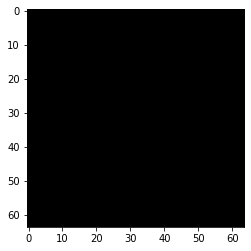

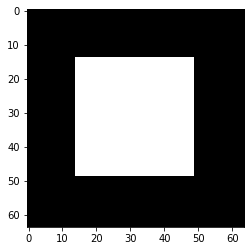

In [5]:
test=binary_generator(2,(img_size,img_size,1),frac=frac_value)
imgs, y=next(test)

display_img(imgs[0])
display_img(imgs[1])
print("Norm L2 "+str(np.linalg.norm(imgs[1])))
print("Norm L2(count pixels) "+str(math.sqrt(np.size(imgs[1][imgs[1]==1]))))

#### for ternary generator

Norm L2(imgs[2]-imgs[0])35.0
Norm L2(imgs[2]) 35.0
Norm L2(count pixels) 35.0


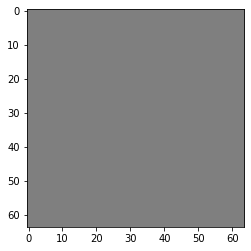

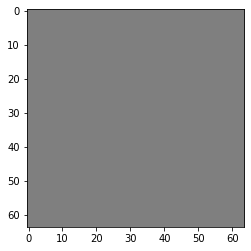

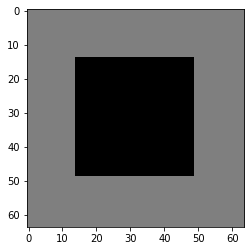

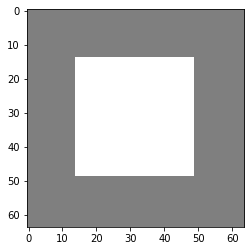

In [6]:
test=ternary_generator(4,(img_size,img_size,1),frac=frac_value)
imgs, y=next(test)

for i in range(4):
    display_img(0.5*(imgs[i]+1.0)) # we ensure that there is no negative value wehn displaying images

print("Norm L2(imgs[2]-imgs[0])"+str(np.linalg.norm(imgs[2]-imgs[0])))
print("Norm L2(imgs[2]) "+str(np.linalg.norm(imgs[2])))
print("Norm L2(count pixels) "+str(math.sqrt(np.size(imgs[2][imgs[2]==-1]))))

### Expe parameters

Now we know the wasserstein distance between the black image and the images with a square on it.
For both binary generator and ternary generator this distance is 35.

We will then compute this distance using a neural network.

In [7]:
batch_size=64
epochs=5
steps_per_epoch=6400

In [8]:
generator = ternary_generator   #binary_generator, ternary_generator
activation = FullSort #ReLU, MaxMin, GroupSort

### Build lipschitz Model

In [10]:
K.clear_session()
## please note that the previous helper function has the same behavior as the following code:
inputs = Input((img_size, img_size, 1))
x = Flatten()(inputs)
x = SpectralDense(128, activation=FullSort())(x)
x = SpectralDense(64, activation=FullSort())(x)
x = SpectralDense(32, activation=FullSort())(x)
y = FrobeniusDense(1, activation=None)(x)
wass = Model(inputs=inputs, outputs=y)
wass.summary()

2021-09-08 18:20:38.075170: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-08 18:20:38.076265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-08 18:20:38.116402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 18:20:38.116842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.83GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2021-09-08 18:20:38.116868: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-08 18:20:38.119558: I tensorflow/stream_executor/platform/default/ds

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
spectral_dense (SpectralDens (None, 128)               1048833   
_________________________________________________________________
spectral_dense_1 (SpectralDe (None, 64)                16513     
_________________________________________________________________
spectral_dense_2 (SpectralDe (None, 32)                4161      
_________________________________________________________________
frobenius_dense (FrobeniusDe (None, 1)                 65        
Total params: 1,069,572
Trainable params: 534,785
Non-trainable params: 534,787
_______________________________________________

In [11]:
optimizer = Adam(lr=0.01)

In [12]:
wass.compile(loss=HKR(alpha=0), optimizer=optimizer, metrics=[KR])

### Learn on toy dataset

In [13]:
wass.fit_generator( generator(batch_size,(img_size,img_size,1),frac=frac_value),
                steps_per_epoch=steps_per_epoch// batch_size,
                epochs=epochs,verbose=1)

/home/thibaut.boissin/envs/tf24/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-08 18:20:39.823710: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-08 18:20:39.842379: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/5
100/100 [==============================] - 6s 50ms/step - loss: -24.9882 - KR: 24.9882
Epoch 2/5
100/100 [==============================] - 5s 49ms/step - loss: -34.9959 - KR: 34.9959
Epoch 3/5
100/100 [==============================] - 5s 49ms/step - loss: -34.9964 - KR: 34.9964
Epoch 4/5
100/100 [==============================] - 5s 50ms/step - loss: -34.9961 - KR: 34.9961
Epoch 5/5
100/100 [==============================] - 5s 50ms/step - loss: -34.9957 - KR: 34.9957


As we can see the loss converge to the value 35 which is the wasserstein distance between the two distributions (square and non-square).